In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [7]:
raw_train=pd.read_csv(r"C:\Users\yidan\Desktop\Projects\Animal Shelter\train\train.csv", sep=",")
raw_test=pd.read_csv(r"C:\Users\yidan\Desktop\Projects\Animal Shelter\test\test.csv", sep=",")

In [8]:
raw_train.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2/12/2014 18:22,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,10/13/2013 12:44,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,1/31/2015 12:28,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,7/11/2014 19:09,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,11/15/2013 12:52,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [9]:
#rename train Id to match with test
raw_train['AnimalID']=raw_train['AnimalID'].str[1:]
raw_train = raw_train.rename(columns={'AnimalID': 'ID'})

Number of adopted animals: AnimalType     10769
OutcomeType    10769
dtype: int64
Number of Return_to_owner animals: AnimalType     4786
OutcomeType    4786
dtype: int64
Number of Transfer animals: AnimalType     9422
OutcomeType    9422
dtype: int64
Number of Euthanasia animals: AnimalType     1555
OutcomeType    1555
dtype: int64
Number of Died animals: AnimalType     197
OutcomeType    197
dtype: int64


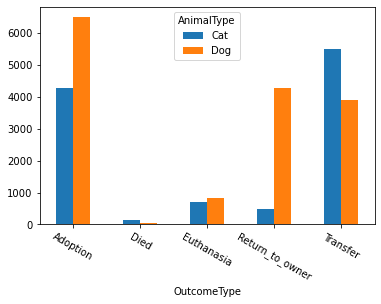

In [10]:
#train outcome based on sex & outcome
#more dogs are adpted, return to owner
#more cats are transfered and adopted

#10,769 adopted pets are neutered and spayed 
#9422 pets are transfered with intact animals occupying the most
#4786 pets are returned to owners with neutered and spayed most
#1555 pets are Euthanasia
#197 pets are died
dog_cat = pd.DataFrame(raw_train[['AnimalType','OutcomeType']])
SexOutcome = dog_cat.groupby(['OutcomeType','AnimalType']).size().unstack()
SexOutcome.plot(kind='bar',rot=-30)
print('Number of adopted animals: '+ str(dog_cat[dog_cat['OutcomeType']=='Adoption'].count()))
print('Number of Return_to_owner animals: '+ str(dog_cat[dog_cat['OutcomeType']=='Return_to_owner'].count()))
print('Number of Transfer animals: '+ str(dog_cat[dog_cat['OutcomeType']=='Transfer'].count()))
print('Number of Euthanasia animals: '+ str(dog_cat[dog_cat['OutcomeType']=='Euthanasia'].count()))
print('Number of Died animals: '+ str(dog_cat[dog_cat['OutcomeType']=='Died'].count()))

<AxesSubplot:xlabel='DateTime'>

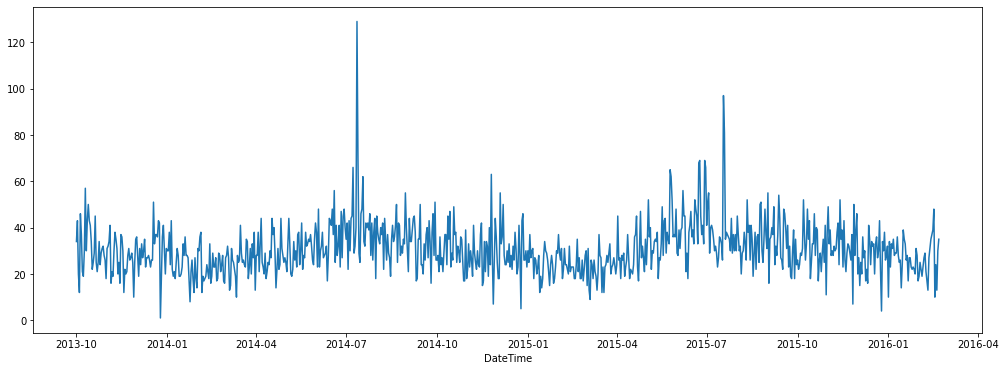

In [11]:
#Animal In Take Time series pattern
#peak intake in July
raw_train["DateTime"] = pd.to_datetime(raw_train["DateTime"]).dt.date
plt.figure(figsize=(17,6))
raw_train["OutcomeType"].groupby(raw_train["DateTime"]).count().plot(kind="line")

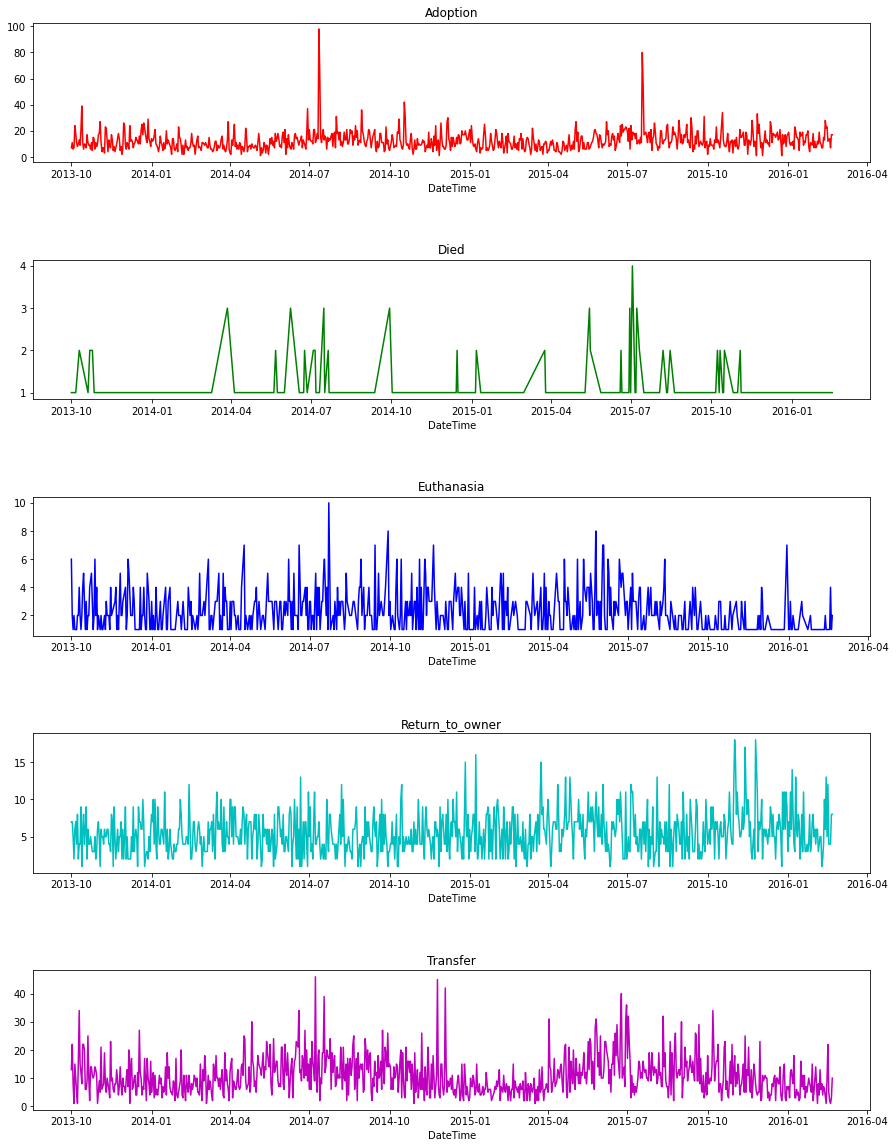

In [12]:
#outcome daily intake pattern
#For each outcome
monthGroup=raw_train["DateTime"].groupby(raw_train["OutcomeType"])
plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust( hspace=0.7)
colors = list('rgbcmyk')
for i, (_, g) in enumerate(monthGroup):
    plt.subplot(5,1,i+1)
    plt.title(_)
    g.groupby(raw_train["DateTime"]).count().plot(kind="line", color=colors[i])

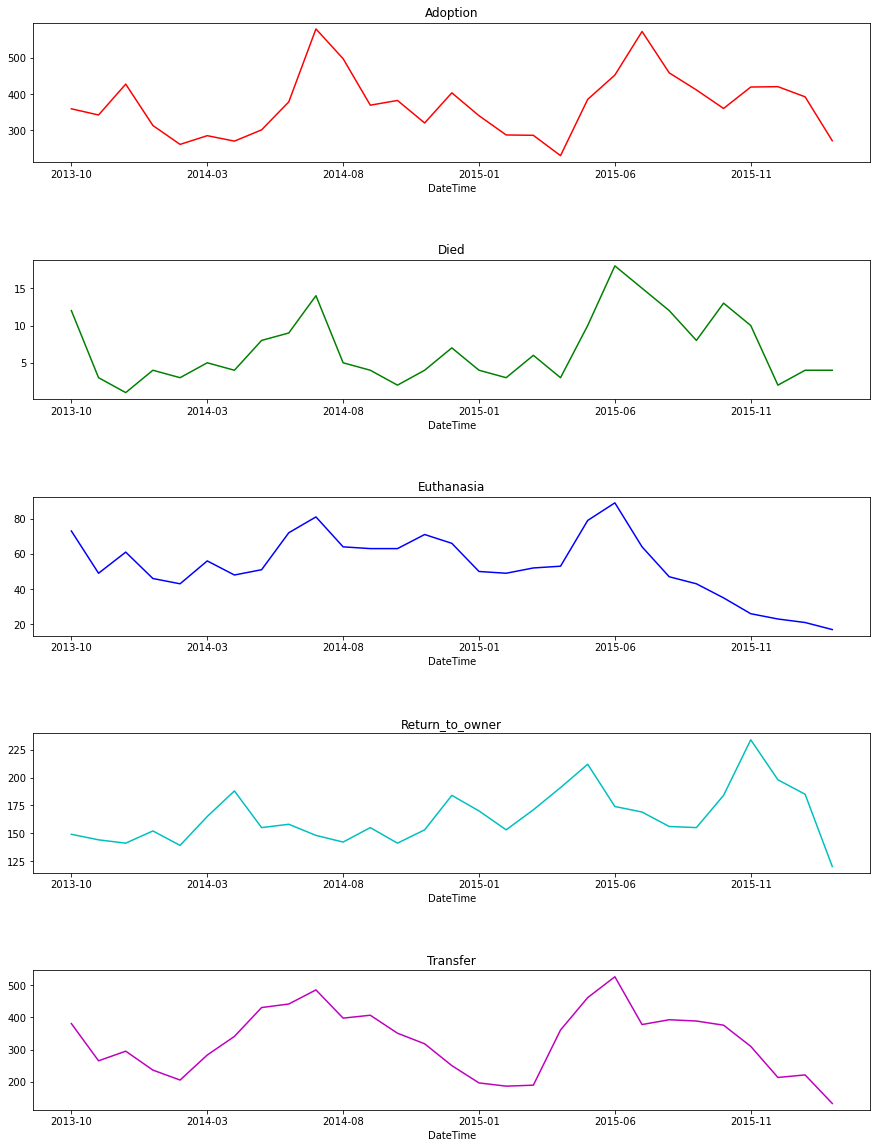

In [13]:
#Monthly time series
#Euthanasia peaked at same time with adoption, transfer and die
#people may come for adoption, or look for transfer before animals receive Euthanasia, 
#while most die comes from Euthanasia
df_ym=raw_train.DateTime.map(lambda x: x.strftime('%Y-%m'))
df_ym_outcomeGroup = df_ym.groupby(raw_train["OutcomeType"])

plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust( hspace=0.7)
colors = list('rgbcmyk')
for i, (_, g) in enumerate(df_ym_outcomeGroup):
    plt.subplot(5,1,i+1)
    plt.title(_)
    g.groupby(df_ym).count().plot(kind="line", color=colors[i])

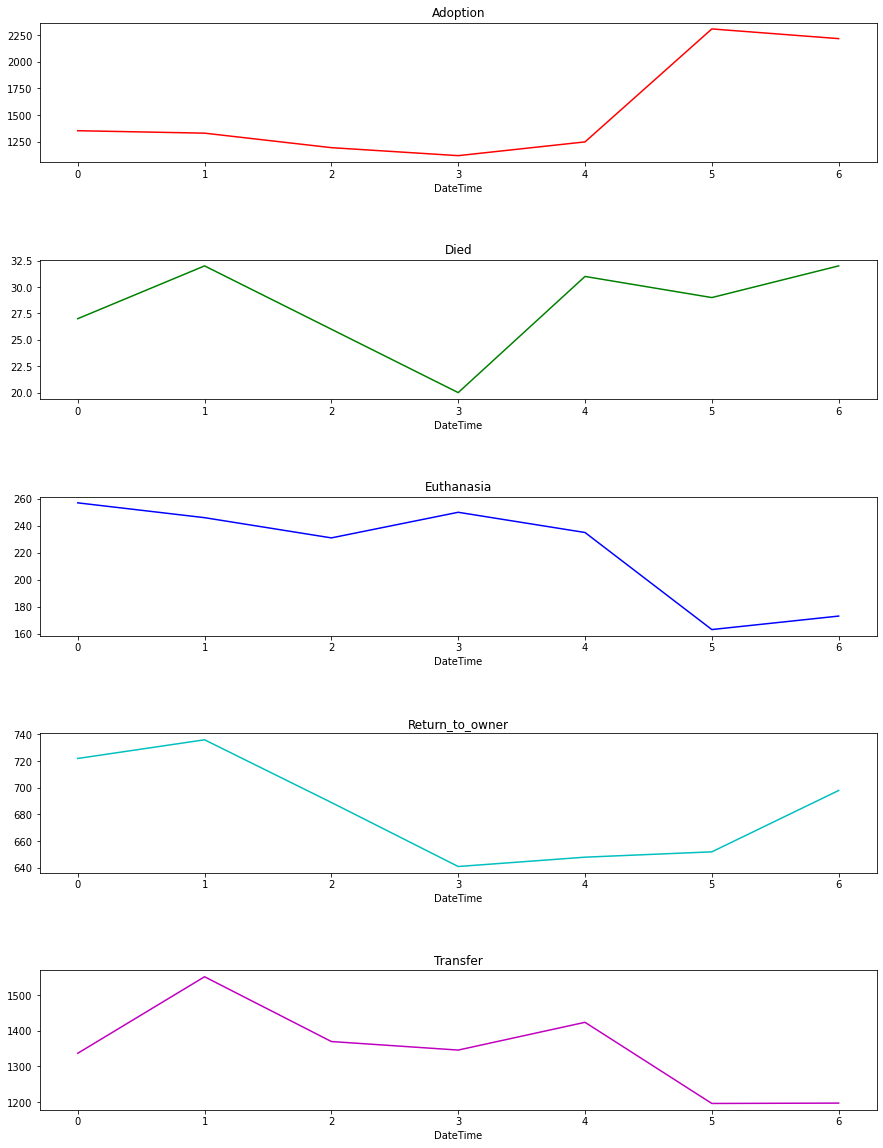

In [14]:
#weekly pattern
#most adoption, transfer and return to owners happen at weekend while Euthanasia happen least on Firday and Saturday
df_dow=pd.to_datetime(raw_train.DateTime).dt.dayofweek
dayinweekGroup=raw_train["DateTime"].groupby(raw_train["OutcomeType"])
plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust( hspace=0.7)
colors = list('rgbcmyk')
for i, (_, g) in enumerate(dayinweekGroup):
    plt.subplot(5,1,i+1)
    plt.title(_)
    g.groupby(df_dow).count().plot(kind="line", color=colors[i])

In [15]:
#convert age into year
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0

<AxesSubplot:xlabel='AgeInYears'>

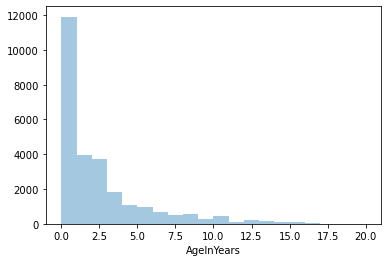

In [16]:
#plot age
raw_train['AgeInYears'] = raw_train.AgeuponOutcome.apply(calc_age_in_years)
sns.distplot(raw_train.AgeInYears, bins = 20, kde=False)

<AxesSubplot:xlabel='AgeInYears'>

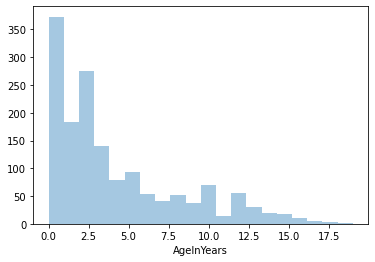

In [17]:
#Suprisingly, Euthanasia are most common in young pets
Euthanasia = raw_train[raw_train['OutcomeType']=='Euthanasia']
Euthanasia_cat = Euthanasia[Euthanasia['AnimalType']=='Cat']
sns.distplot(Euthanasia.AgeInYears, bins = 20, kde=False)

In [18]:
# convert test age -> years
raw_test['AgeInYears'] = raw_test.AgeuponOutcome.apply(calc_age_in_years)

In [19]:
#train
# Prepare for training data
ytrain = raw_train["OutcomeType"]
Xtrain = raw_train.drop(["OutcomeType","OutcomeSubtype","AgeuponOutcome","ID","Name"],axis=1)
Xtrain.SexuponOutcome = Xtrain.SexuponOutcome.fillna('Unknown')

#Datetime-> year, month, week
xdt=pd.to_datetime(Xtrain.DateTime)
Xtrain["dow"] = xdt.dt.dayofweek
Xtrain["month"] = xdt.dt.month
Xtrain["year"] = xdt.dt.year

Xtrain=Xtrain.drop(["DateTime"],axis=1)
Xtrain.head()

,AnimalType,SexuponOutcome,Breed,Color,AgeInYears,dow,month,year
0,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,1.000000,2,2,2014
1,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,1.000000,6,10,2013
2,Dog,Neutered Male,Pit Bull Mix,Blue/White,2.000000,5,1,2015
3,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream,0.057692,4,7,2014
4,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan,2.000000,4,11,2013


In [20]:
#test
# Prepare for testing data
#ytest = raw_test["OutcomeType"]
Xtest = raw_test.drop(["AgeuponOutcome","ID","Name"],axis=1)
Xtest.SexuponOutcome = Xtest.SexuponOutcome.fillna('Unknown')

#Datetime-> year, month, week
xdt=pd.to_datetime(Xtest.DateTime)
Xtest["dow"] = xdt.dt.dayofweek
Xtest["month"] = xdt.dt.month
Xtest["year"] = xdt.dt.year

Xtest=Xtest.drop(["DateTime"],axis=1)
Xtest.head()

,AnimalType,SexuponOutcome,Breed,Color,AgeInYears,dow,month,year
0,Dog,Intact Female,Labrador Retriever Mix,Red/White,0.833333,0,10,2015
1,Dog,Spayed Female,German Shepherd/Siberian Husky,Black/Tan,2.000000,5,7,2014
2,Cat,Neutered Male,Domestic Shorthair Mix,Brown Tabby,1.000000,2,1,2016
3,Dog,Intact Male,Collie Smooth Mix,Tricolor,0.333333,5,12,2013
4,Dog,Neutered Male,Miniature Poodle Mix,White,2.000000,3,9,2015


# Dummy Method

In [21]:
Xtrain["train"] = 1
Xtest["train"] = 0
conjunto = pd.concat([Xtrain, Xtest])
conjunto_encoded = pd.get_dummies(conjunto, columns=conjunto.columns)
train = conjunto_encoded[conjunto_encoded["train_1"] == 1]
test = conjunto_encoded[conjunto_encoded["train_0"] == 1]
train.drop(["train_0","train_1"], axis=1, inplace=True)
test.drop(["train_0","train_1"], axis=1, inplace=True)

In [22]:
train.head()

,AnimalType_Cat,AnimalType_Dog,SexuponOutcome_Intact Female,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,Breed_Abyssinian Mix,Breed_Affenpinscher Mix,Breed_Afghan Hound Mix,...,month_7,month_8,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [23]:
test.head()

,AnimalType_Cat,AnimalType_Dog,SexuponOutcome_Intact Female,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,Breed_Abyssinian Mix,Breed_Affenpinscher Mix,Breed_Afghan Hound Mix,...,month_7,month_8,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [24]:
#Training a RF to get some metrics
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, ytrain, test_size=0.1)
forest = RandomForestClassifier(n_estimators=250, n_jobs=2)
forest.fit(X_train, y_train)
y_pred_val = forest.predict(X_val)

# Let's see the train accuracy
tra_score=forest.score(X_train, y_train)
print("Training accuracy ",tra_score)
print(classification_report(y_val, y_pred_val))
print("Validation accuracy ",accuracy_score(y_val, y_pred_val))

Training accuracy  0.9930162953109412
                 precision    recall  f1-score   support

       Adoption       0.64      0.86      0.74      1066
           Died       0.40      0.10      0.16        20
     Euthanasia       0.20      0.02      0.03       171
Return_to_owner       0.47      0.33      0.39       507
       Transfer       0.69      0.66      0.68       909

       accuracy                           0.63      2673
      macro avg       0.48      0.39      0.40      2673
   weighted avg       0.60      0.63      0.60      2673

Validation accuracy  0.6333707444818556


In [25]:
y_pred_val

array(['Adoption', 'Adoption', 'Return_to_owner', ..., 'Return_to_owner',
       'Adoption', 'Adoption'], dtype=object)

In [26]:
#Training a RF with the complete training set
forest = RandomForestClassifier(n_estimators=500, n_jobs=2)
forest.fit(train, ytrain)
y_pred = forest.predict_proba(test)

In [38]:
y_val#.unique()

13964           Transfer
12128           Adoption
18419           Adoption
25246         Euthanasia
11282           Transfer
              ...       
26643    Return_to_owner
6853            Adoption
1953     Return_to_owner
569      Return_to_owner
21780           Adoption
Name: OutcomeType, Length: 2673, dtype: object

In [37]:
y_pred#.shape

array([[0.114     , 0.004     , 0.11466667, 0.20533333, 0.562     ],
       [0.752     , 0.        , 0.01      , 0.106     , 0.132     ],
       [0.385     , 0.002     , 0.014     , 0.164     , 0.435     ],
       ...,
       [0.03      , 0.        , 0.112     , 0.004     , 0.854     ],
       [0.556     , 0.        , 0.012     , 0.326     , 0.106     ],
       [0.078     , 0.002     , 0.186     , 0.264     , 0.47      ]])

In [28]:
# Let's see the test accuracy
score=forest.score(train, ytrain)
print("Testing accuracy ",score)

Testing accuracy  0.9923304276254256


In [29]:
results = pd.read_csv("sample_submission.csv")
results['Adoption'], results['Died'], results['Euthanasia'], results['Return_to_owner'], results['Transfer'] = y_pred[:,0], y_pred[:,1], y_pred[:,2], y_pred[:,3], y_pred[:,4]
results.to_csv("submission.csv", index=False)
results.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'